In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.utils import class_weight
from keras.layers import BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('train_3.2.csv')
df.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

- Датафрейм содержит 101763 строчек
- Типы данных соответствуют значениям столбцам
- Целевая переменная __defects__ имеет булевое значение - переведём в числовой

In [4]:
df['defects'] = df['defects'].astype(int)
df['defects']

0         0
1         0
2         0
3         1
4         0
         ..
101758    0
101759    0
101760    0
101761    0
101762    0
Name: defects, Length: 101763, dtype: int64

In [5]:
df.isnull().sum()

id                   0
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

- Пропусков нет

### Разобьем данные на тренировочную и валидационную части

<Axes: >

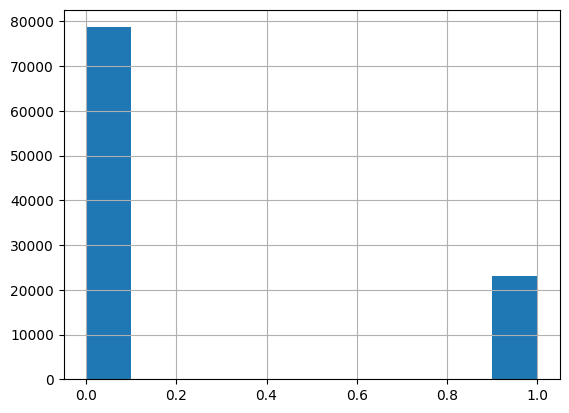

In [6]:
X = df.drop(columns=['defects'])
y = df['defects']

y.hist()

Очень сильный дисбаланс классов

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train, y_val = y_train.to_numpy(), y_val.to_numpy()

Проведём масштабирование

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [9]:
def create_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='roc_auc', curve='ROC')])
    
    return model

In [10]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([0.64653187, 2.20611349])

In [11]:
model = create_model()

history = model.fit(X_train, y_train,
           validation_data=(X_val, y_val),
           epochs=20,
           batch_size=4096,
           class_weight={0:class_weights[0], 1:class_weights[1]})

Epoch 1/20


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6428 - roc_auc: 0.6994 - val_loss: 0.5848 - val_roc_auc: 0.7726
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5765 - roc_auc: 0.7764 - val_loss: 0.5524 - val_roc_auc: 0.7813
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5673 - roc_auc: 0.7820 - val_loss: 0.5550 - val_roc_auc: 0.7852
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5621 - roc_auc: 0.7853 - val_loss: 0.5581 - val_roc_auc: 0.7881
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5591 - roc_auc: 0.7871 - val_loss: 0.5531 - val_roc_auc: 0.7896
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5571 - roc_auc: 0.7882 - val_loss: 0.5471 - val_roc_auc: 0.7902
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5557 - roc_auc: 0.7892 - val_loss: 0.5539 - val_roc_auc: 0.7906
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5555 - roc_auc: 0.7888 - val_loss: 0.5647 - val_roc_auc: 0.7904
Epoch 9/20
20/20 ━

In [12]:
def check_metrics(history, figure_name):

    train = history.history[f'{figure_name}']
    val = history.history[f'val_{figure_name}']

    # Построение графика лосса и валидационного лосса
    epochs = range(1, len(train) + 1)
    plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')
    plt.plot(epochs, val, 'b', label=f'Validation {figure_name}')
    plt.title(f'Training and Validation {figure_name}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{figure_name}')
    plt.legend()
    plt.show()

C:\Users\Alexey\AppData\Local\Temp\ipykernel_5868\2180351603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


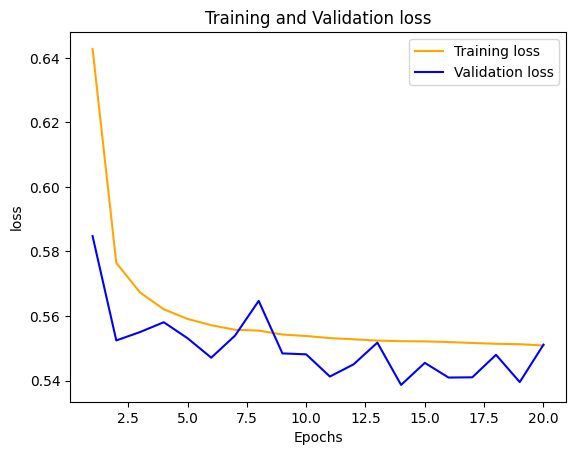

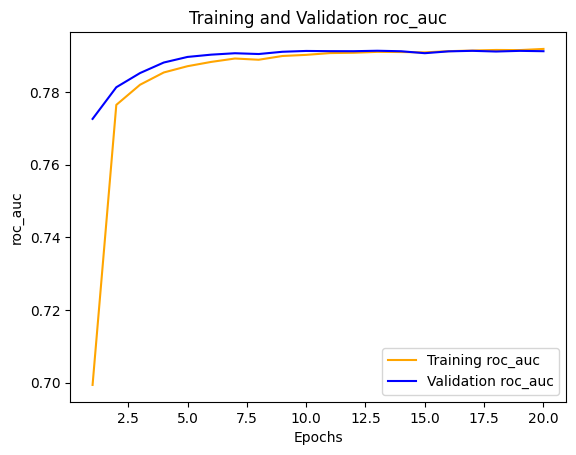

In [13]:
check_metrics(history, 'loss')
check_metrics(history, 'roc_auc')

Видим плавный рост ROC-AUC как на тренировочных так и на валидационных данных, с дальнейшим их сходством

Построим корреляционную матрицу

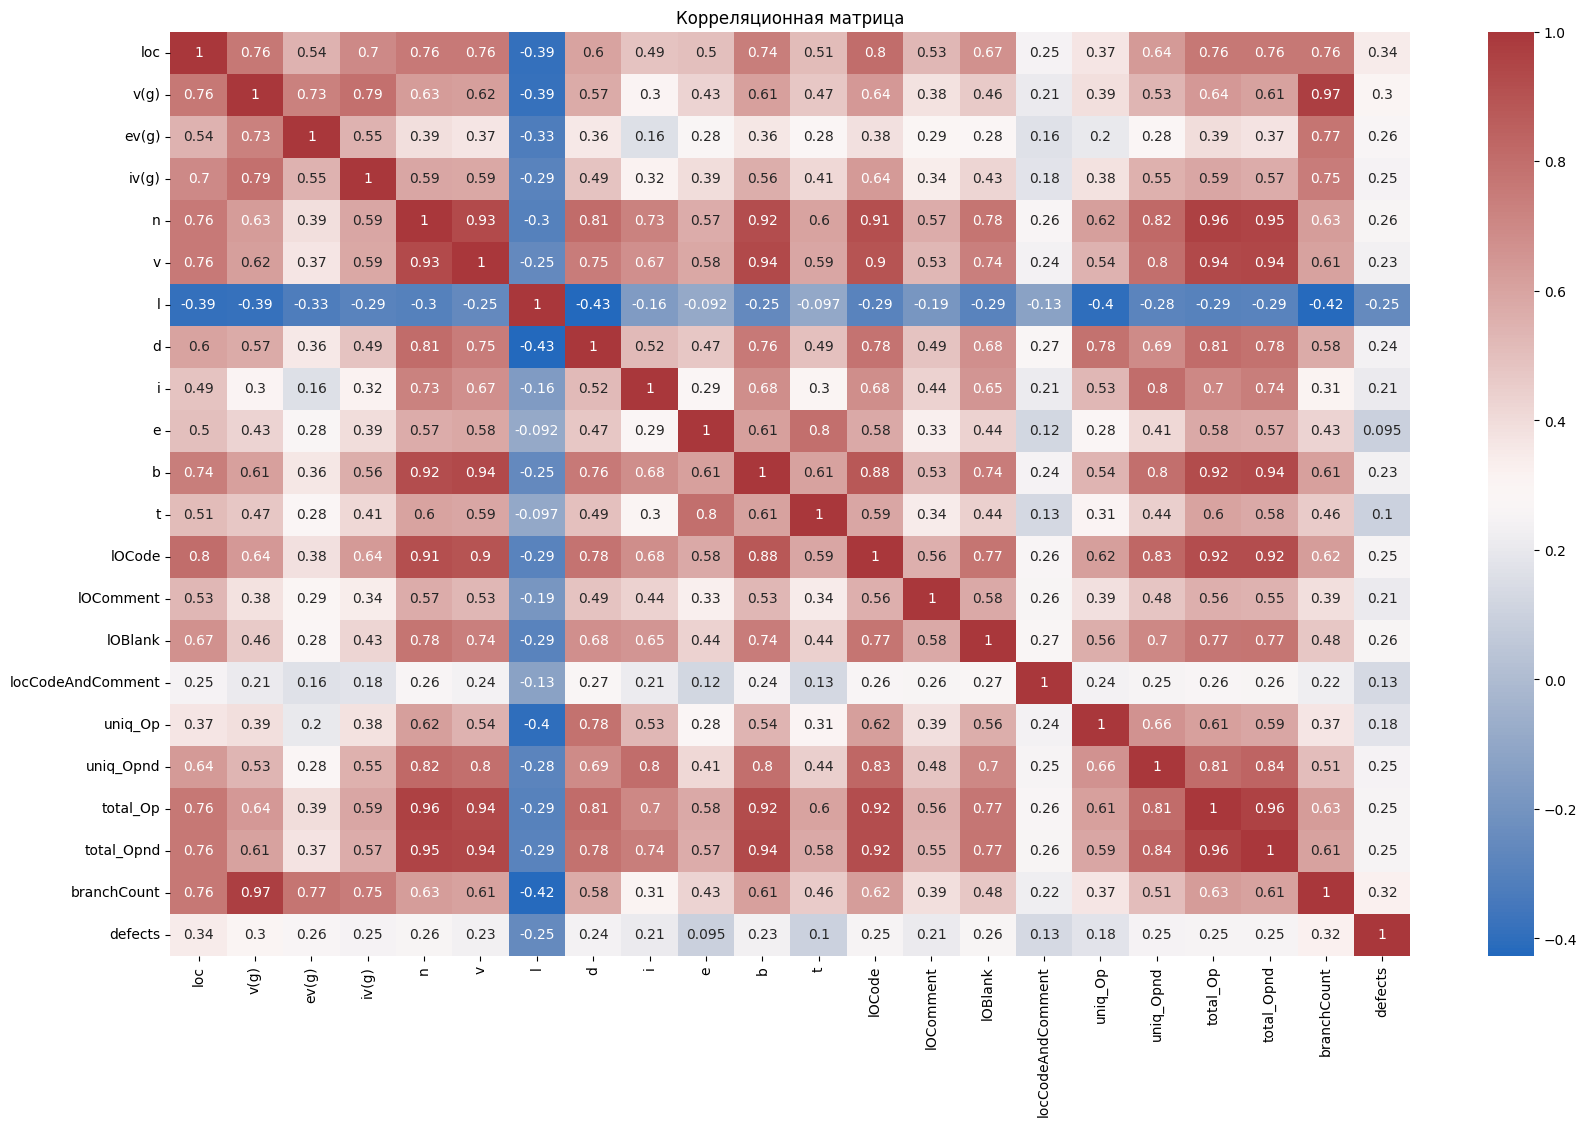

In [14]:
plt.figure(figsize=(20, 12))
sns.heatmap(df.drop(columns=['id']).corr(), annot=True, cmap='vlag')

plt.title('Корреляционная матрица')
plt.show()

Буду предерживаться такого правила: __если два признака сильно коррелируют между собой, буду из них оставлять тот, который сильнее коррелирует с целевой переменной__

- n с v, оставляем n
- v(g) с branchCount, оставляем branchCount
- n с b, оставляем n
- n с IOCode, оставляем n
- n с Total_Op, оставляем n
- n с total_Opnd, оставляем n

### Удалим ненужные признаки

In [15]:
X = df.drop(columns=['id', 'v', 'v(g)', 'b', 'lOCode', 'total_Op', 'total_Opnd', 'defects'])
y = df['defects']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train, y_val = y_train.to_numpy(), y_val.to_numpy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

def create_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='roc_auc', curve='ROC')])
    
    return model

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

model = create_model()

history = model.fit(X_train, y_train,
           validation_data=(X_val, y_val),
           epochs=20,
           batch_size=4096,
           class_weight={0:class_weights[0], 1:class_weights[1]})


Epoch 1/20


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6085 - roc_auc: 0.7550 - val_loss: 0.5643 - val_roc_auc: 0.7748
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5712 - roc_auc: 0.7760 - val_loss: 0.5594 - val_roc_auc: 0.7826
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5622 - roc_auc: 0.7826 - val_loss: 0.5504 - val_roc_auc: 0.7862
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5592 - roc_auc: 0.7854 - val_loss: 0.5567 - val_roc_auc: 0.7879
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5572 - roc_auc: 0.7872 - val_loss: 0.5601 - val_roc_auc: 0.7891
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5561 - roc_auc: 0.7878 - val_loss: 0.5550 - val_roc_auc: 0.7900
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5550 - roc_auc: 0.7889 - val_loss: 0.5568 - val_roc_auc: 0.7904
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5541 - roc_auc: 0.7897 - val_loss: 0.5473 - val_roc_auc: 0.7907
Epoch 9/20
20/20 ━

C:\Users\Alexey\AppData\Local\Temp\ipykernel_5868\2180351603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


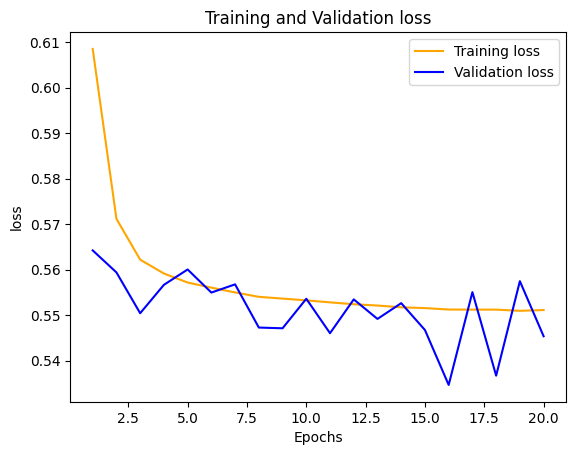

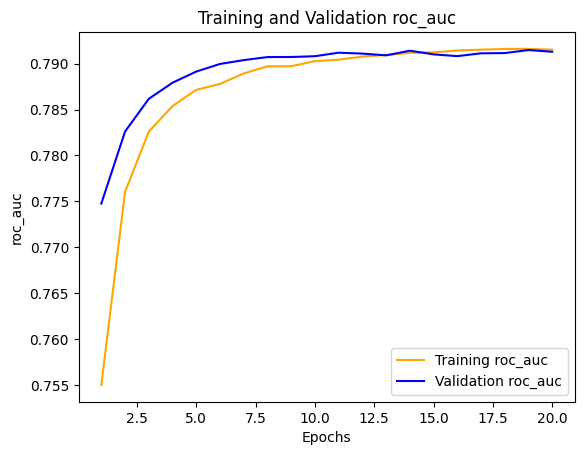

In [16]:
check_metrics(history, 'loss')
check_metrics(history, 'roc_auc')

Качество метрики ROC-AUC на валидационной части чуть улучшилось после удаления фичей с сильной мультиколлинеарностью

In [18]:
def create_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='roc_auc', curve='ROC')])
    
    return model

In [22]:
model = create_model()

early_stopping = EarlyStopping(monitor='val_roc_auc', patience=5)
save_best_weights = ModelCheckpoint(filepath='.weights.h5',
                                    save_weights_only=True,
                                    monitor='val_roc_auc',
                                    mode='max',
                                    save_best_only=True)

history = model.fit(X_train, y_train,
           validation_data=(X_val, y_val),
           epochs=30,
           batch_size=4096,
           class_weight={0:class_weights[0], 1:class_weights[1]},
           callbacks=[early_stopping,save_best_weights])

Epoch 1/30


c:\Users\Alexey\Desktop\Data_science\homework\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.6632 - roc_auc: 0.7279 - val_loss: 0.6019 - val_roc_auc: 0.7782
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6080 - roc_auc: 0.7538 - val_loss: 0.5838 - val_roc_auc: 0.7818
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5949 - roc_auc: 0.7636 - val_loss: 0.5751 - val_roc_auc: 0.7829
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5875 - roc_auc: 0.7665 - val_loss: 0.5695 - val_roc_auc: 0.7852
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5816 - roc_auc: 0.7709 - val_loss: 0.5658 - val_roc_auc: 0.7868
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5797 - roc_auc: 0.7717 - val_loss: 0.5584 - val_roc_auc: 0.7865
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5754 - roc_auc: 0.7759 - val_loss: 0.5578 - val_roc_auc: 0.7883
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5758 - roc_auc: 0.7753 - val_loss: 0.5553 - val_roc_auc: 0.7880
Epoch 9/30


C:\Users\Alexey\AppData\Local\Temp\ipykernel_5868\2180351603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


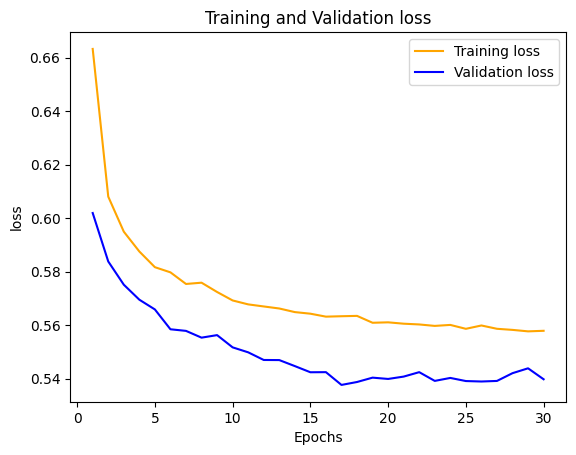

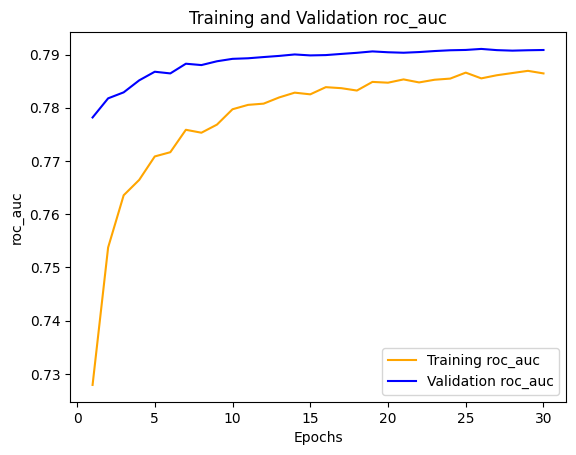

In [23]:
check_metrics(history, 'loss')
check_metrics(history, 'roc_auc')

In [24]:
model.load_weights(".weights.h5")

In [30]:
roc_auc_score(y_val, model.predict(X_val))

637/637 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step


0.7910794820229332

### Вывод:

- Помогли улучшить качество: __BatchNormalization__, __Dropout(0.2)__ и __class_weight='balanced'__

- Признаки, которые улучшили качество: удалён __id__
- __Снижение мультиколлинеарности:__ по коррматрице из сильно коррелирующих групп (например, n, v, total_Op, total_Opnd, branchCount) оставляли представителя с большей связью с таргетом (сохранили n и branchCount, убрали v, v(g), b, IOCode, total_Op, total_Opnd)

- Лучшая метрика ROC-AUC на валидации = __0.79__